# Feature Analysis

In [18]:
import helpers as h
import numpy as np
import pandas as pd

import scipy.stats as stats

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

data = pd.read_csv("../data/creditcard.csv")
Features = ['V%d' % n for n in range(1, 29)]
df_fraud = data[data['Class']==1]
df_legit = data[data['Class']==0]

### Helper Functions

In [2]:
def bootstrap_mean(df, statistic, samples=500):
    """
    Returns an pandas series of mean bootstrap values for the statistic
    for each of the columns in the dataframe.

    Parameters
    ----------
    df: Pandas dataframe
    statistic: valid arguments include 'mean', 'median', 'std'
    samples: number of bootstrap samples to generate

    Returns
    -------
    Pandas Series
    """

    df_bootstrap = pd.DataFrame(columns=df.columns)
    for _ in range(samples):
        bootstrap = df.sample(n=len(df), replace=True, axis=0)
        if statistic == 'mean':
            df_bootstrap = df_bootstrap.append(bootstrap.mean(), ignore_index=True)
        elif statistic == 'median':
            df_bootstrap = df_bootstrap.append(bootstrap.median(), ignore_index=True)
        elif statistic == 'std':
            df_bootstrap = df_bootstrap.append(bootstrap.std(), ignore_index=True)
        else:
            print("Invalid statitic. Please use 'mean', 'median' or 'sdt'")
            return None
    s = df_bootstrap.mean()
    df = pd.DataFrame(s).reset_index()
    df.columns = ['Feature', statistic]
    return df

In [3]:
def ttest(sample1, sample2, Features):
    """
    Returns a dataframe with a single row containing the p values for each Feature when sample1
    is compared against sample2. Features are columns in the dataframe.

    Parameters
    ----------
    sample1: Pandas dataframe represting the sample transactions and their associated features.
    sample2: Pandas dataframe represting the sample transactions and their associated features.
    Features: List of column names from input dataframes that are to be evaluated.

    Returns
    -------
    Pandas DataFrame
    """

    p_lst = []
    for f in Features:
        stat, p_val = stats.ttest_ind(sample1[f], sample2[f], equal_var=False)  
        p_lst.append(p_val)
    df = pd.DataFrame(p_lst, index=Features).reset_index()
    df.columns = ['Feature','p_val']
    return df

### End of Helper Functions

In [4]:
### Plot feature ttest comparison

In [30]:
fraud_all = data[(data['Class']==1)]
legit_all = data[(data['Class']==0)]
df0 = ttest(fraud_all, legit_all, Features)

fraud_low = data[(data['Class']==1) & (data['Amount']<=1)]
legit_low = data[(data['Class']==0) & (data['Amount']<=1)]
df1 = ttest(fraud_low, legit_low, Features)

fraud_high = data[(data['Class']==1) & (data['Amount']>20)]
legit_high = data[(data['Class']==0) & (data['Amount']>20)]
df2 = ttest(fraud_high, legit_high, Features)

fraud_high = data[(data['Class']==1) & (data['Amount']<=1)]
legit_high = data[(data['Class']==0) & (data['Amount']>1)]
df3 = ttest(fraud_high, legit_high, Features)

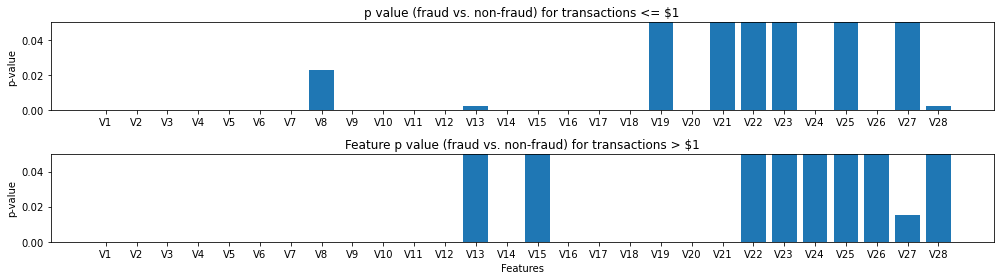

In [37]:
def plot_pval(ax, grp1, grp2, Features, title):
    df = ttest(grp1, grp2, Features)
    y = df['p_val']
    ax.bar(Features,y)
    ax.set_ylim(0, 0.05)
    ax.set_title(title)

fig, axs = plt.subplots(2,1,figsize=(14,4))
grp1 = df_fraud[df_fraud['Amount']<=1]
grp2 = df_legit[df_legit['Amount']<=1]
title = 'p value (fraud vs. non-fraud) for transactions <= $1'
axs[0].set_ylabel("p-value")
axs[1].set_ylabel("p-value")
axs[1].set_xlabel("Features")
plot_pval(axs[0], grp1, grp2, Features, title)

grp3 = df_fraud[df_fraud['Amount']>1]
grp4 = df_legit[df_legit['Amount']>1]
title = 'Feature p value (fraud vs. non-fraud) for transactions > $1'
plot_pval(axs[1], grp3, grp4, Features, title)
plt.tight_layout()
fig.savefig("../img/features_pval.png")

In [7]:
fraud_low = data[(data['Class']==1) & (data['Amount']<=1)]
legit_low = data[(data['Class']==0) & (data['Amount']<=1)]
df1 = ttest(fraud_low, legit_low, Features)

In [38]:


amt_threshold = 1.00
p_thresh = 0.01

fraud_sample_low = data[(data['Class']==1) & (data['Amount']<=amt_threshold)]
legit_sample_low = data[(data['Class']==0) & (data['Amount']<=amt_threshold)]

fraud_sample_high = data[(data['Class']==1) & (data['Amount']>amt_threshold)]
legit_sample_high = data[(data['Class']==0) & (data['Amount']>amt_threshold)]

def relevant_features(fraud_sample, legit_sample, Features, p_thresh):
    low_p_features = []
    for f in Features:
        stat, p_val = stats.ttest_ind(fraud_sample[f], legit_sample[f], equal_var=False) 
        if p_val < p_thresh:
            low_p_features.append(f)
    return low_p_features

def recommended_features(fraud_sample_low, legit_sample_low, fraud_sample_high, legit_sample_high ):
    low_amt_f = relevant_features(fraud_sample_low, legit_sample_low, Features, p_thresh)
    high_amt_f = relevant_features(fraud_sample_high, legit_sample_high, Features, p_thresh)
    
    both = [x for x in low_amt_f if x in high_amt_f]
    low_only = [x for x in low_amt_f if x not in high_amt_f]
    high_only = [x for x in high_amt_f if x not in low_amt_f]                    
                        
    print(f'Relevenant Features for Both models: \r\n{both}')
    print(f'\nAdditional Features for Low Amount model only: {low_only}')
    print(f'\nAdditional Features for High Amount model only: {high_only}')
    return None

recommended_features(fraud_sample_low, legit_sample_low, fraud_sample_high, legit_sample_high )

Relevenant Features for Both models: 
['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18', 'V20']

Additional Features for Low Amount model only: ['V13', 'V15', 'V24', 'V26', 'V28']

Additional Features for High Amount model only: ['V8', 'V19', 'V21']


In [ ]:
def predictors(grp1, grp2, Features):
    df1 = ttest(fraud_low, legit_low, Features)

## Legitimate Transaction Sample

In [ ]:
# non-fraud population stats
df_stat_legit = data[Features][data['Class']==0].agg(['mean', 'median', 'std'])
df_stat_legit.head()

In [ ]:
#non bootstrap dataset just for fun to compare
df_stat_fraud = data[Features][data['Class']==1].agg(['mean', 'median', 'std'])
df_stat_fraud.head()

In [ ]:
df_stats_bsfraud['std'].sort_values()

## Bootstrap Fraud Sample

In [87]:
df_fraud = data[data['Class']==1][Features]
df_bootstrap = bootstrap_mean(df_fraud, 'std', samples=500)
# print(df_bootstrap)

In [ ]:
### Fraud Ammount V